In [1]:
import cv2
import csv
import os
import numpy as np
from PIL import Image

import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.gridspec as gridspec

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import utils


In [2]:
base_dir='/home/paperspace/data/BehavioralCloning/data'
input_file=os.path.join(base_dir,'driving_log.csv')
data=pd.read_csv(input_file)
print(len(data))


8036


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00cf18de10>]],
      dtype=object)

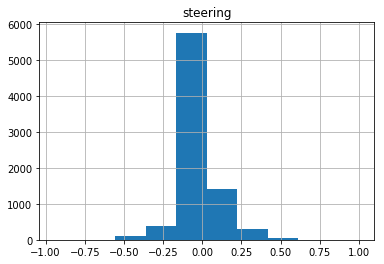

In [27]:
data.hist(column='steering')

In [3]:
def get_file_path(source_path):
    filename=source_path.split('/')[-1]
    img_dir=os.path.join(base_dir,'IMG')
    return os.path.join(img_dir,filename)

def read_image(col,index):
    path_file=data[col][index].strip()
    image=cv2.imread(get_file_path(path_file))
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def read_image_file(filepath):
    path_file=filepath.strip()
    image=cv2.imread(get_file_path(path_file))
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def plot_img(index):

    image_left=read_image('left',index)
    image_center=read_image('center',index)
    image_right=read_image('right',index)
    
    fig = plt.figure(figsize=(30,20))

    a=fig.add_subplot(1,3,1)
    plt.imshow(image_left)
    a.set_title('left')

    a=fig.add_subplot(1,3,2)
    plt.imshow(image_center)
    a.set_title('center')

    a=fig.add_subplot(1,3,3)
    plt.imshow(image_right)
    a.set_title('right')
    

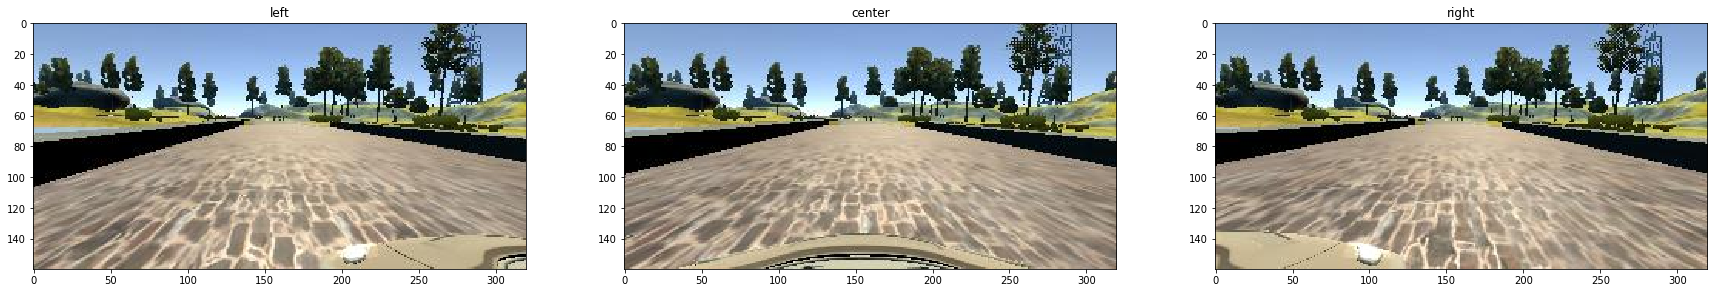

In [28]:
plot_img(0)

In [4]:
def augment_brightness_camera_images(image):
    '''
    :param image: Input image
    :return: output image with randomly adjusted brightness
    '''
    # convert to HSV so that its easy to adjust brightness
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .25+np.random.uniform()

    # Apply the brightness reduction to the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [5]:
def plot_two_images(image1,image2,title2,title1='Original'):
    fig = plt.figure(figsize=(30,20))

    a=fig.add_subplot(1,2,1)
    plt.imshow(image1)
    a.set_title(title1)

    a=fig.add_subplot(1,2,2)
    plt.imshow(image2)
    a.set_title(title2)


(160, 320, 3)


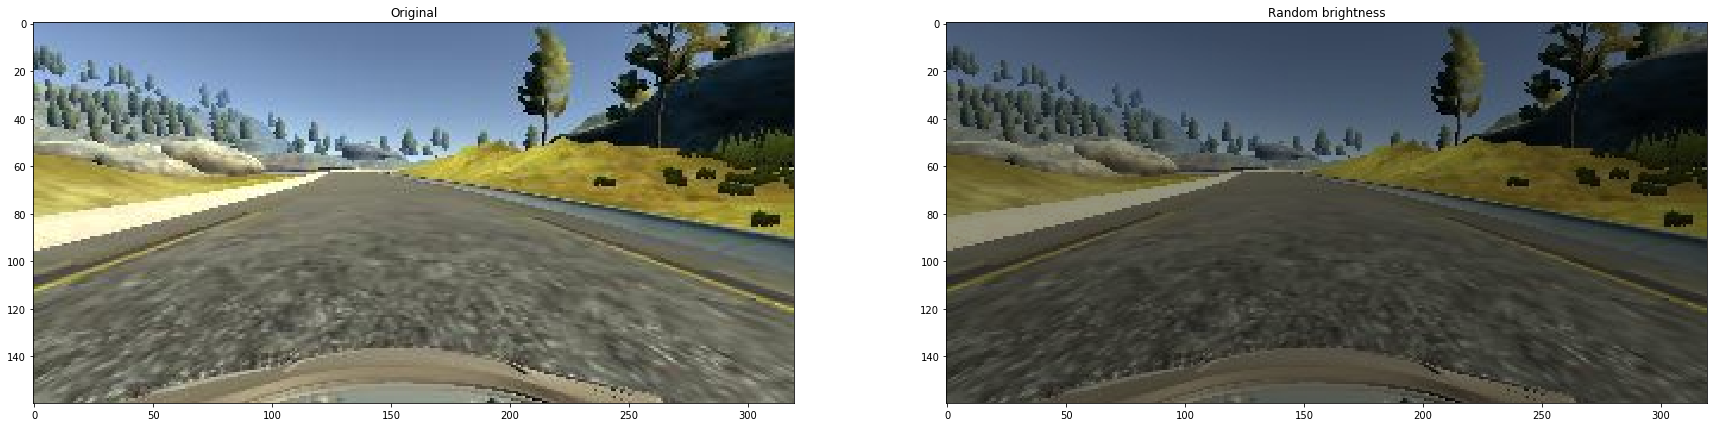

In [29]:
index=np.random.randint(len(data))
input_file=os.path.join(base_dir,'driving_log.csv')
image1=read_image('center',index)


aug_image=augment_brightness_camera_images(image1)
print(aug_image.shape)
plot_two_images(image1,aug_image,'Random brightness')

In [6]:
# horizontally flip image
def flip_angle(image,y_steer):
    image = cv2.flip(image,1)
    y_steer = -y_steer
    
    return image,y_steer

(160, 320, 3)


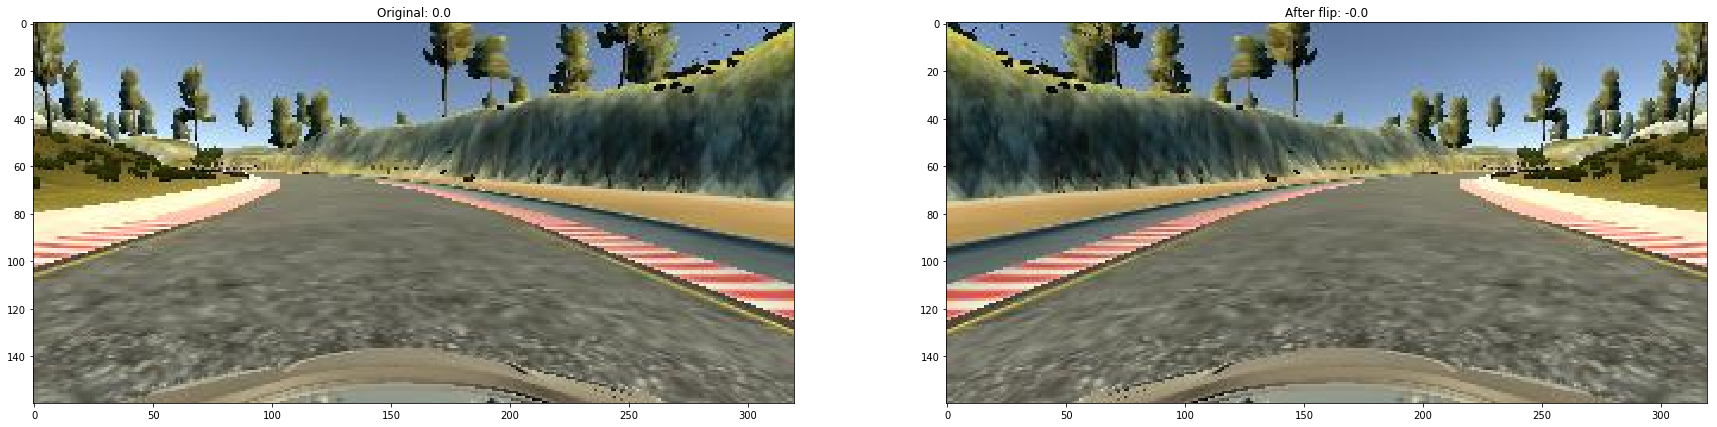

In [30]:
index=np.random.randint(len(data))
input_file=os.path.join(base_dir,'driving_log.csv')
image1=read_image('center',index)
steer=data['steering'][index]
# print(steer)
flip_image,flip_steer=flip_angle(image1,steer)
print(flip_image.shape)
# print('After flip: '+str(flip_steer))
plot_two_images(image1,flip_image,'After flip: '+str(flip_steer),title1='Original: '+str(steer))

In [7]:
def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

(160, 320, 3)


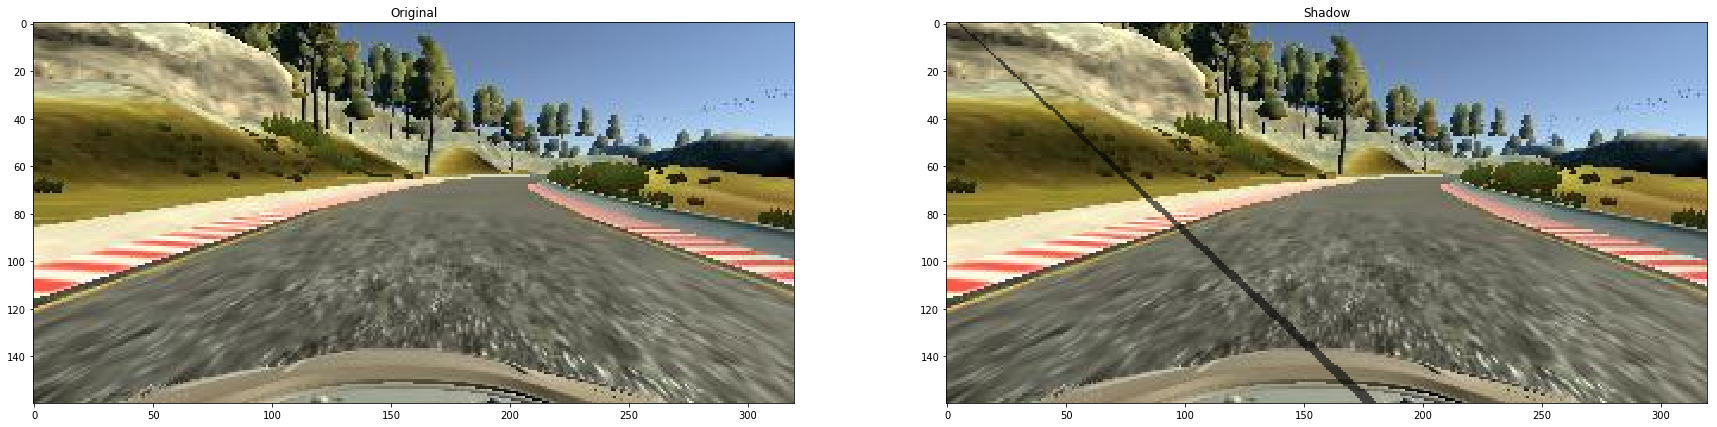

In [31]:
index=np.random.randint(len(data))
input_file=os.path.join(base_dir,'driving_log.csv')
image1=read_image('center',index)
steer=data['steering'][index]
# print(steer)
shadow_img=add_random_shadow(image1)
print(shadow_img.shape)
# print('After flip: '+str(flip_steer))
plot_two_images(image1,shadow_img,'Shadow')

In [8]:
# shift image
# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def trans_image(image,steer,trans_range):
    cols=image.shape[1]
    rows=image.shape[0]
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang


(160, 320, 3)


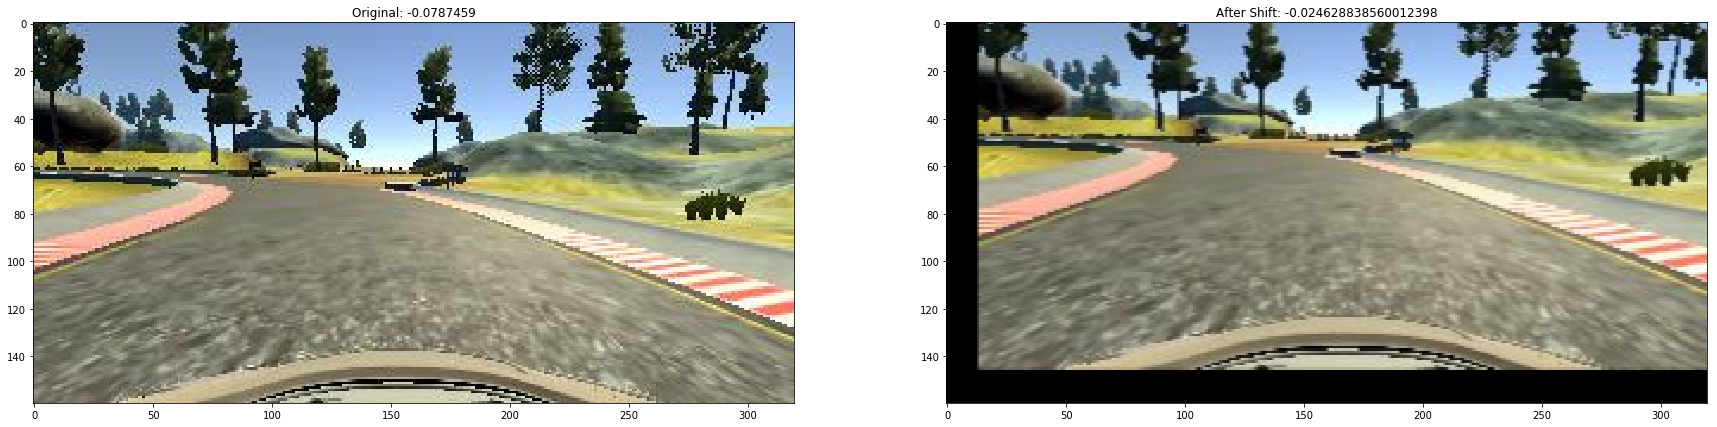

In [32]:
index=np.random.randint(len(data))
input_file=os.path.join(base_dir,'driving_log.csv')
image1=read_image('center',index)
steer=data['steering'][index]
# print(steer)
shift_img,shift_steer=trans_image(image1,steer,100)
print(shift_img.shape)
# print('After flip: '+str(flip_steer))
plot_two_images(image1,shift_img,'After Shift: '+str(shift_steer),title1='Original: '+str(steer))

In [9]:
# create data generators
from keras.preprocessing.image import ImageDataGenerator

# center,left,right,steering,throttle,brake,speed

train_data = pd.read_csv(os.path.join(base_dir, 'driving_log_train.csv'),names = ["center", "left", "right", "steering","throttle","brake","speed"])
valid_data = pd.read_csv(os.path.join(base_dir, 'driving_log_validation.csv'),names = ["center", "left", "right", "steering","throttle","brake","speed"])
overtrain_data=pd.read_csv(os.path.join(base_dir, 'driving_log_overtrain.csv'),names = ["center", "left", "right", "steering","throttle","brake","speed"])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
def augment_image(image,steer):
    aug_img = image
    aug_steer=steer
    
    aug_img = augment_brightness_camera_images(aug_img)
    aug_img,aug_steer =flip_angle(aug_img,aug_steer)
    aug_img = add_random_shadow(aug_img)
    aug_img,aug_steer = trans_image(aug_img,aug_steer,100)
    return aug_img,aug_steer

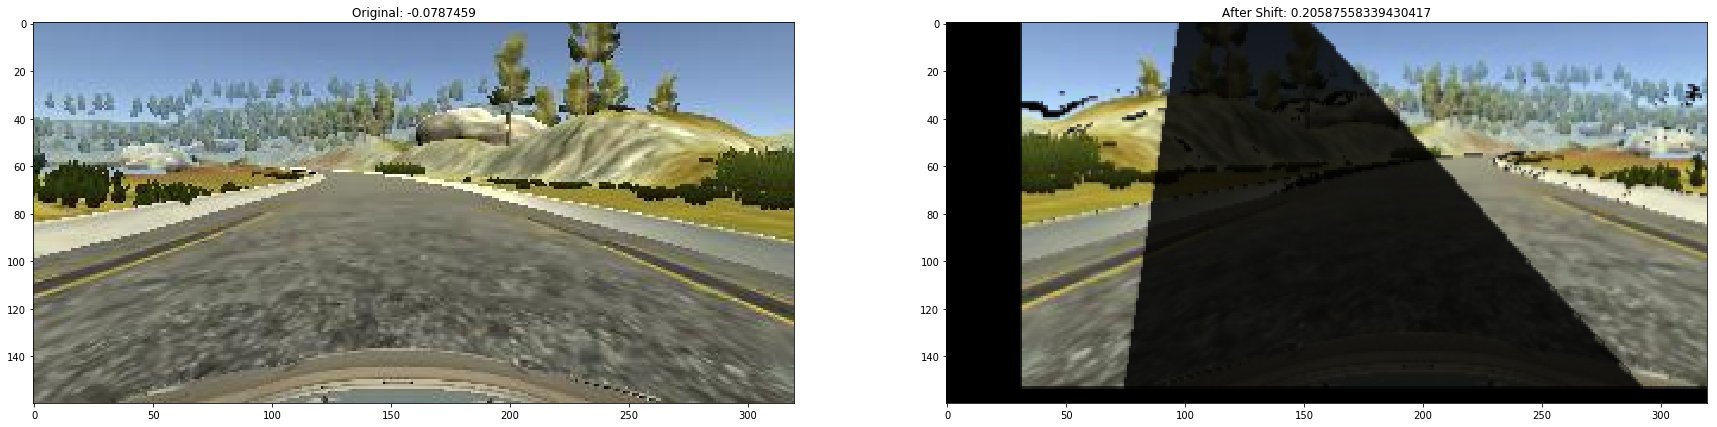

In [33]:
index=np.random.randint(len(data))

image1=read_image('center',index)
steer=data['steering'][index]
# print(steer)
shift_img,shift_steer=augment_image(image1,steer)
# print(shift_img.shape)
# print('After flip: '+str(flip_steer))
plot_two_images(image1,shift_img,'After Shift: '+str(shift_steer),title1='Original: '+str(steer))

In [ ]:
data['left'][0]

In [ ]:
t_img=read_image_file(data['left'][0])
plt.imshow(t_img)

In [11]:
def get_image_angle(row,col,angle):
#     print('get_image')
    image = read_image_file(row[col])
    angle = angle + float(row['steering'])
    return image,angle

In [12]:
col=['left','center','right']
st_calibrations=[0.25,0.0,-0.25]

def generator(samples,batch_size=32):
    num_samples = len(samples)
    
    while True:
        utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
           
            images = []
            angles = []
            k = 0

            index=0
#             print('offset:',offset)
            while k < batch_size:            
                row = batch_samples.iloc[index]
#                 print('index',index)
                
                col_types=zip(col,st_calibrations)
                for img_t, st_calib in col_types:
#                     print('k:',k)
                    if k >= batch_size:
                        break
            
                    img,st_angle=get_image_angle(row,img_t,st_calib)
                
                     # Drop neutral-ish steering angle images with some probability
                    if abs(st_angle) < 0.05 and np.random.random_sample() <= 0.25 :
                        continue
                        
                    if np.random.random_sample() <= 0.8:
                        img, st_angle = augment_image(img,st_angle)

                    images.append(img)
                    angles.append(st_angle)
                    k += 1
                
                index += 1
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
                
            yield utils.shuffle(X_train, y_train)

In [13]:
# extract x,y from csv data
# np.random.seed(21)
overtraining_generator = generator(overtrain_data,batch_size=3)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [14]:

sample=next(overtraining_generator)

In [15]:
sample[0].shape


(3, 160, 320, 3)

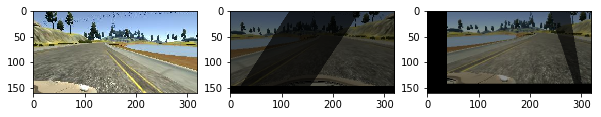

In [34]:
fig = plt.figure(figsize=(10,5))

for i in range(3):
    a=fig.add_subplot(1,3,i+1)
    plt.imshow(sample[0][i])


In [35]:
# generator on all images and plot hist
# np.random.seed(21)
data_generator = generator(data,batch_size=2000)
datagen=next(data_generator)
len(datagen[1])

2000

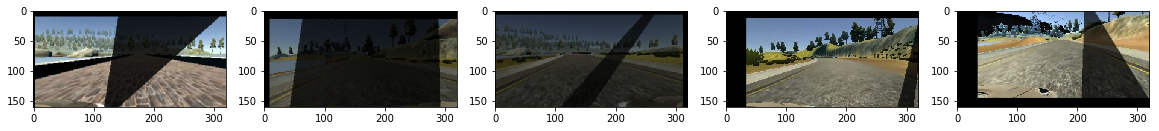

In [36]:
fig = plt.figure(figsize=(20,10))

for i in range(5):
    a=fig.add_subplot(1,5,i+1)
    plt.imshow(datagen[0][i])

(array([  1.,   2.,   4.,   3.,   7.,  26.,  24.,  80., 112., 104., 163.,
        158., 165., 133., 176., 163., 170., 130., 172.,  85.,  88.,  22.,
          4.,   3.,   2.,   2.,   1.]),
 array([-0.920795  , -0.85600776, -0.79122051, -0.72643327, -0.66164602,
        -0.59685878, -0.53207153, -0.46728429, -0.40249704, -0.3377098 ,
        -0.27292256, -0.20813531, -0.14334807, -0.07856082, -0.01377358,
         0.05101367,  0.11580091,  0.18058816,  0.2453754 ,  0.31016264,
         0.37494989,  0.43973713,  0.50452438,  0.56931162,  0.63409887,
         0.69888611,  0.76367336,  0.8284606 ]),
 <a list of 27 Patch objects>)

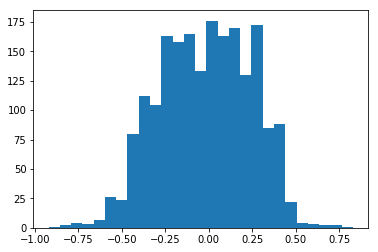

In [37]:
plt.hist(datagen[1],bins="auto")
# data is more distributed

In [17]:
#train the model
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Cropping2D 
from keras.layers import Activation,Conv2D,MaxPooling2D
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [18]:
# create keras model

model=Sequential()

model.add(Cropping2D(cropping=((80,14),(60,60)),input_shape=(160,320,3)))

model.add(Lambda(lambda x :(x/127.5) - 1,input_shape=(66,200,3)))
model.add(Conv2D(24,(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(36,(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(48,(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))

model.add(Flatten())
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


In [19]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
__________

In [20]:
model.compile(loss='mse',optimizer='adam')



In [ ]:
# #  train on overtrain sample data
# history= model.fit_generator(
#         overtraining_generator,
#         steps_per_epoch=len(overtrain_data),
#         epochs=4)

In [ ]:
# history.history

In [21]:
# define early stopping callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
len(train_data)

In [ ]:
len(valid_data)

In [22]:
# now train on train and valid data
batch_size=32
training_generator = generator(train_data,batch_size=batch_size)
valid_generator = generator(valid_data,batch_size=batch_size)

In [23]:


earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit_generator(training_generator,steps_per_epoch=128,epochs=5,
        validation_data=valid_generator,
        validation_steps=32,
        verbose=1)

Epoch 1/5
128/128 [==============================] - 15s 115ms/step - loss: 0.0726 - val_loss: 0.0543
Epoch 2/5
128/128 [==============================] - 14s 109ms/step - loss: 0.0470 - val_loss: 0.0395
Epoch 3/5
128/128 [==============================] - 14s 108ms/step - loss: 0.0418 - val_loss: 0.0387
Epoch 4/5
128/128 [==============================] - 14s 108ms/step - loss: 0.0389 - val_loss: 0.0361
Epoch 5/5
128/128 [==============================] - 14s 107ms/step - loss: 0.0350 - val_loss: 0.0341


In [24]:
history.history

{'loss': [0.07262815060676076,
  0.04699262305803131,
  0.041823233928880654,
  0.038856860701343976,
  0.03500937146600336],
 'val_loss': [0.05430005642119795,
  0.03946395282400772,
  0.038734558736905456,
  0.036054376454558223,
  0.03410699643427506]}

In [25]:
from keras.models import load_model

# # Creates a HDF5 file 'my_model.h5'
# model.save('vgg_model_pre.h5')

# Save the weights
model.save_weights('nvidia_model.h5')

# Save the model architecture
with open('nvidia_model.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))